In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
## SHG calculation
def CoupledAmplitude_SHG(P1_avg_0 = 1e-6, P2_avg_0 = 1e-6, phi1_0 = np.pi/2, phi2_0 = -np.pi/2, 
                     lam1 = 1.064e-6, n1 =2.1 , n2=2.1, d_eff = (20e-12)*(2/np.pi), 
                     T_p = 30e-12, R_p =  1e3, L= 10e-3, N_z = 1000):
    """ 
    Parameters:
    phi1_0[float]   : phase of the input FH beam
    phi2_0[float]   : phase of the input SH beam
    lam1[float]     : FH wavelength in units of m
    L[float]        : total crystal length in units of m
    n1[float]       : refractive index of the material at the FH wavelength
    n2 [float]      : refractive index of the material at the SH wavelength, if n2 = n1 the system is phasematched
    d_eff[float]    : effective nonlinearity in units of m/V, look at boyd eq (2.4.3) for effective d with QPM
    P1_avg_0[float] : input average FH power for the pulsed input in units of W
    P2_avg_0[float] : input average SH power for the pulsed input in units of W
    T_p[float]      : pulse width for the FH and the SH pulses in units of s
    R_p[float]      : repetition rate in units of 1/s
    N_z[int]        : number of sampling points
    
    Returns:
    I1,I2,P1,P2, P1_avg, P2_avg
    """
    # Parmeters from input
    c=3e8                       #speed of light in m/s
    epsilon_0=8.854187817e-12   #vacuum permittivity in F/m
    P1_0     = P1_avg_0/(T_p*R_p) #input peak power for the FH [W]
    P2_0     = P2_avg_0/(T_p*R_p) #input peak power for the SH [W]
    P_FH_0   = P1_avg_0/R_p #input FH pulse energy [J=Ws]  (not used in calculation)
    P_SH_0   = P2_avg_0/R_p #input SH pulse energy [J=Ws] (not used in calculation)
    omega1   = 2*np.pi*c/lam1 #frequency of FH [s]
    omega2   = 2*omega1 #frequency of SH [s]
    k1       = n1*omega1/c
    k2       = n2*omega2/c
    
    #S_eff=(1e-6)**2 or use the Rayleigh length z_0 of a Gaussian beam, assuming that the crystal
    #length L=2*z_0=2*np.pi*(w_0**2)/(lam1/n1) where w_0 is the waist radius of the Gaussian beam 
    #which gives w_0=sqrt((L*(lam1/n1))/(2*np.pi)), the beam radius at the Rayleigh length is sqrt(2)*w_0
    w_0   = np.sqrt((L*(lam1/n1))/(2*np.pi)) #waist radius of the Gaussian beam
    S_eff = np.pi*(np.sqrt(2)*w_0)**2 #effective area of the collimated beam in the crystal in units of m**2
    
    # Prefactor in cooupled amplitude equation
    Q1     = 2*(omega1**2)*d_eff/(k1*(c**2)) 
    Q2     = (omega2**2)*d_eff/(k2*(c**2))  
    
    
    # Create grid
    dz    = L/(N_z-1)
    L_    = np.linspace(0,L, N_z)
    A1    = np.zeros(N_z, dtype = np.complex128)
    A2    = np.zeros(N_z, dtype = np.complex128)
    A1[0] = np.sqrt(P1_0/(2*n1*c*epsilon_0*S_eff))*np.exp(1j*phi1_0) 
    A2[0] = np.sqrt(P2_0/(2*n2*c*epsilon_0*S_eff))*np.exp(1j*phi2_0) 
    
    '''
    # Attention I is Equal the Power of BOTH Beams
    I1_0  = P1_0/S_eff
    I2_0  = P2_0/S_eff
    I     = I1_0 + I2_0
    '''
    
    #Phase Missmatch
    del_kz = 2*k1-k2 
    
    # Compute Coupled Amplitudes evolution along L in crystal (Boyd: 2.6.10,2.6.11) 
    
    #Initial code didnt have z in the exponent, here I added it
    #the sign for the exponent is negative for FH and positive for SH as in Boyd
    for i in range(1,N_z):
        A1[i] = A1[i-1]+(1j*Q1*A2[i-1]*np.conjugate(A1[i-1])*dz)*np.exp(-1j*del_kz*L_[i-1])
        A2[i] = A2[i-1]+(1j*Q2*(A1[i-1]**2)*dz)*np.exp(1j*del_kz*L_[i-1])

    # Compute final Results
    I1     = 2*n1*c*epsilon_0*(np.abs(A1)**2) #FH Poynting vector in units of W/m**2
    I2     = 2*n2*c*epsilon_0*(np.abs(A2)**2) #SH Poynting vector in units of W/m**2
    
    P1     = I1*S_eff #FH peak power in units of W
    P2     = I2*S_eff #FH peak power in units of W
    P1_avg = P1*(T_p*R_p) #FH average power in units of W (multiplied with pulse width and repetition rate)
    P2_avg = P2*(T_p*R_p) #FH average power in units of W (multiplied with pulse width and repetition rate)
    
    return {"L": L_, "A1": A1, "A2": A2, "I1": I1, "I2": I2,
            "P1": P1, "P2": P2, "P1_avg": P1_avg, "P2_avg": P2_avg}

In [17]:
def RungeKutta_SHG(P1_avg_0 = 1e-6, P2_avg_0 = 1e-6, phi1_0 = np.pi/2, phi2_0 = np.pi, 
                     lam1 = 1.064e-6, n1 =2.1 , n2=2.1, d_eff = (20e-12)*(2/np.pi), 
                     T_p = 30e-12, R_p =  1e3, L=10e-3, N_z=1000, type='dimensional', crystal='bulk'):
  
    """ 
    Parameters:
    phi1_0[float]   : phase of the input FH beam
    phi2_0[float]   : phase of the input SH beam
    lam1[float]     : FH wavelength in units of m
    L[float]        : total crystal length in units of m
    n1[float]       : refractive index of the material at the FH wavelength
    n2 [float]      : refractive index of the material at the SH wavelength, if n2 = n1 the system is phasematched
    d_eff[float]    : effective nonlinearity in units of m/V, look at boyd eq (2.4.3) for effective d with QPM
    N_z[int]        : number of sampling points

    Returns:
    L, I1,I2,P1,P2, P1_avg, P2_avg
        """
    def d(z):
        if crystal=='bulk':
            return d_eff
        elif crystal=='PPLN':
            return d_eff*np.sign(np.cos(2*np.pi*z/Lambda))
        
    def f1(Q1, A1, A2, del_k, z):
        if crystal=='bulk':
            return 1j*Q1*d(z)*A2*np.conjugate(A1)*np.exp(-1j*del_k*z)
        elif crystal=='PPLN':
            return 1j*Q1*d(z)*A2*np.conjugate(A1)*np.exp(-1j*(del_k-2*np.pi/Lambda)*z)

    def f2(Q2, A1, A2, del_k, z):
        if crystal=='bulk':
            return 1j*Q2*d(z)*A1**2*np.exp(1j*del_k*z)
        elif crystal=='PPLN':
            return 1j*Q2*d(z)*A1**2*np.exp(1j*(del_k-2*np.pi/Lambda)*z)
    
    c=3e8                       #speed of light in m/s
    epsilon_0=8.854187817e-12   #vacuum permittivity in F/m
    P1_0     = P1_avg_0/(T_p*R_p) #input peak power for the FH [W]
    P2_0     = P2_avg_0/(T_p*R_p) #input peak power for the SH [W]
    omega1   = 2*np.pi*c/lam1 #frequency of FH [s]
    omega2   = 2*omega1 #frequency of SH [s]
    
    k1       = n1*omega1/c
    k2       = n2*omega2/c
    w_0   = np.sqrt((L*(lam1/n1))/(2*np.pi)) #waist radius of the Gaussian beam
    S_eff = np.pi*(np.sqrt(2)*w_0)**2 #effective area of the collimated beam in the crystal in units of m**2
    # Prefactor in cooupled amplitude equation
    Q1     = 2*(omega1**2)/(k1*(c**2)) 
    Q2     = (omega2**2)/(k2*(c**2))  
    #Lambda=5.87e-6
    Lambda=1e-6
    del_k=2*k1-k2
        
    # Create grid
    dz    = L/(N_z-1)
    z    = np.linspace(0,L, N_z)
    A1    = np.zeros(N_z, dtype = np.complex128)
    A2    = np.zeros(N_z, dtype = np.complex128)
    # Initial conditions
    A1[0] = np.sqrt(P1_0/(2*n1*c*epsilon_0*S_eff))*np.exp(1j*phi1_0) 
    A2[0] = np.sqrt(P2_0/(2*n2*c*epsilon_0*S_eff))*np.exp(1j*phi2_0) 
    I1_0  = P1_0/S_eff
    I2_0  = P2_0/S_eff
    
    # Normalization factor for the field
    factor_1=np.sqrt((P1_0*n2+P2_0*n1)/(2*n1*n2*c*epsilon_0*S_eff)) 

    # Normalization factor for the distance (from Boyd)
    l=np.sqrt(2*n1**2*n2*epsilon_0*c/(I1_0+I2_0))*c/(2*omega1*d_eff)

    # Phase Missmatch
    
    Γ=np.real(np.cos(2*phi1_0-phi2_0+del_k*z)*A1[0]**2*A2[0]/factor_1**2)
    #print('Γ=', round(Γ[0]))
    # Phase mismatch factor according to Boyd (already =25 brings a lot of oscillations)
    del_s=del_k*l
    #if n1==n2:
        #print('Perfect Phase Matching')
    #else:
        #print('Phase Mismatch Factor: Δs=', round(del_s))
        
    for i in range(1,N_z):
        # k1 terms
        k1_E1 = f1(Q1, A1[i-1], A2[i-1], del_k, z[i-1])
        k1_E2 = f2(Q2, A1[i-1], A2[i-1], del_k, z[i-1])
        #k2 terms
        k2_E1 = f1(Q1, A1[i-1] + 0.5 * dz * k1_E1, A2[i-1] + 0.5 * dz * k1_E2, del_k, z[i-1] + 0.5 * dz)
        k2_E2 = f2(Q2, A1[i-1] + 0.5 * dz * k1_E1, A2[i-1] + 0.5 * dz * k1_E2, del_k, z[i-1] + 0.5 * dz)
        # k3 terms
        k3_E1 = f1(Q1, A1[i-1] + 0.5 * dz * k2_E1, A2[i-1] + 0.5 * dz * k2_E2, del_k, z[i-1] + 0.5 * dz)
        k3_E2 = f2(Q2, A1[i-1] + 0.5 * dz * k2_E1, A2[i-1] + 0.5 * dz * k2_E2, del_k, z[i-1] + 0.5 * dz)
        #k4 terms
        k4_E1 = f1(Q1, A1[i-1] + dz * k3_E1, A2[i-1] + dz * k3_E2, del_k, z[i-1] + dz)
        k4_E2 = f2(Q2, A1[i-1] + dz * k3_E1, A2[i-1] + dz * k3_E2, del_k, z[i-1] + dz)

        # Update the fields using the weighted sum of k1, k2, k3, and k4 (NOT normalized)
        A1[i] = A1[i-1] + (dz / 6.0) * (k1_E1 + 2*k2_E1 + 2*k3_E1 + k4_E1)
        A2[i] = A2[i-1] + (dz / 6.0) * (k1_E2 + 2*k2_E2 + 2*k3_E2 + k4_E2)
    # Compute final Results
    I1     = 2*n1*c*epsilon_0*(np.abs(A1)**2) 
    I2     = 2*n2*c*epsilon_0*(np.abs(A2)**2) 
    
    P1     = I1*S_eff #FH peak power in units of W
    P2     = I2*S_eff #FH peak power in units of W
    P1_avg = P1*(T_p*R_p) #FH average power in units of W (multiplied with pulse width and repetition rate)
    P2_avg = P2*(T_p*R_p) #FH average power in units of W (multiplied with pulse width and repetition rate)
    
    if type=='dimensionless':
        A1=A1/factor_1
        A2=A2/factor_1
        z=z/l

    return z, A1, A2, I1 ,I2 ,P1 ,P2 ,P1_avg, P2_avg

In [21]:
import scipy.special as sp
from scipy.optimize import fsolve
def analytics(P1_avg_0=1e-6, P2_avg_0=1e-6,phi1_0=np.pi/2, phi2_0=np.pi, lam1=1.064e-6,
            n1=2.1, n2=2.1, d_eff=(20e-12)*(2/np.pi),
            T_p = 30e-12, R_p =  1e3, L=10e-3, N_z=1000, type='dimensional'):
    """ 
    Parameters:
    u0[float]       : initial value of the fundamental harmonic
    v0[float]       : initial value of the second harmonic
    phi1_0[float]   : phase of the input FH beam
    phi2_0[float]   : phase of the input SH beam
    lam1[float]     : FH wavelength in units of m
    L[float]        : total crystal length in units of m
    n1[float]       : refractive index of the material at the FH wavelength
    n2 [float]      : refractive index of the material at the SH wavelength, if n2 = n1 the system is phasematched
    d_eff[float]    : effective nonlinearity in units of m/V, look at boyd eq (2.4.3) for effective d with QPM
    P1_avg_0[float] : input average FH power for the pulsed input in units of W
    P2_avg_0[float] : input average SH power for the pulsed input in units of W
    T_p[float]      : pulse width for the FH and the SH pulses in units of s
    R_p[float]      : repetition rate in units of 1/s
    N_z[int]        : number of sampling points
    
    Returns:
    z,I1,I2,P1,P2, P1_avg, P2_avg

    Function implements the analytical solution of the coupled
    mode equations for SHG in a bulk crystal. The solution is based on the elliptic
    Jacobi function and is taken from https://doi.org/10.1103/PhysRev.127.1918. 
    This solution is valid for any phase mismatch for the input beams 
    as long as Δk=0.

    """
    def equation(u):
        return sp.ellipj(u, gamma)[0] - sn_value_0  # Extract the sn(u, m) value
    
    c=3e8                       #speed of light in m/s
    epsilon_0=8.854187817e-12   #vacuum permittivity in F/m
    P1_0     = P1_avg_0/(T_p*R_p) #input peak power for the FH [W]
    P2_0     = P2_avg_0/(T_p*R_p) #input peak power for the SH [W]
    omega1   = 2*np.pi*c/lam1 #frequency of FH [s]
    omega2   = 2*omega1 #frequency of SH [s]
    w_0   = np.sqrt((L*(lam1/n1))/(2*np.pi)) #waist radius of the Gaussian beam
    S_eff = np.pi*(np.sqrt(2)*w_0)**2 #effective area of the collimated beam in the crystal in units of m**2
    
    dz    = L/(N_z-1)
    
    z  = np.linspace(0,L, N_z)
    #z= L 

    A1_0 = np.sqrt(P1_0/(2*n1*c*epsilon_0*S_eff))*np.exp(1j*phi1_0) 
    A2_0 = np.sqrt(P2_0/(2*n2*c*epsilon_0*S_eff))*np.exp(1j*phi2_0) 
    I1_0  = P1_0/S_eff
    I2_0  = P2_0/S_eff
    
    k1       = n1*omega1/c
    k2       = n2*omega2/c
    if 2*k1-k2!=0:  #should alway be zero otherwise the analytics doesn't work
        print('Analytics cannot be found because Δk!=0')
        return 

    # Normalization factors for the amplitude and the distance (from Boyd)
    factor_1=np.sqrt((P1_0*n2+P2_0*n1)/(2*n1*n2*c*epsilon_0*S_eff)) 
    l=np.sqrt(2*n1**2*n2*epsilon_0*c/(I1_0+I2_0))*c/(2*omega1*d_eff)
    
    #because the analytical solution is dimensionless, we normalize all the input values
    u0=np.abs(A1_0)/factor_1
    v0=np.abs(A2_0)/factor_1
    z=z/l
    
    #constants for our analytical solution
    Gamma=u0**2*v0*np.cos(2*phi1_0-phi2_0)
    sign=np.sign(np.sin(2*phi1_0-phi2_0)) #this sign determines the sign of the integration constant z0
    
    #finding roots of the third order polynomial equation on the right side of the differential equation
    coeffs=[1, -2,1,-Gamma**2]
    roots=np.roots(coeffs)
    va2, vb2, vc2 = np.round(np.real(np.sort(roots)), 14)
    gamma=(vb2-va2)/(vc2-va2)
    #getting constants of integration
    if np.round(v0**2,6)==np.round(va2,6):
        va2=v0**2
    sn_value_0=np.sqrt((v0**2-va2)/(vb2-va2))
    z0_guess=1.
    u=fsolve(equation, z0_guess)[0]
    z0=1/np.sqrt(vc2-va2)*u

    #the analytical solution for amplitudes
    v2=va2+(vb2-va2)*(sp.ellipj(np.sqrt(vc2-va2)*(z-sign*z0), gamma)[0])**2 #amplitude squared of SH
    u2=1-v2

    u=np.sqrt(u2)
    v=np.sqrt(v2)

    theta0=2*phi1_0-phi2_0
    #SHG for theta0=3pi/2
    #phi1=phi1_0+0.5*u0**2*v0*np.cos(theta0)*(z-sign*z0+np.cosh(z-sign*z0)*np.sinh(z-sign*z0)+sign*z0-np.cosh(-sign*z0)*np.sinh(-sign*z0))
    #phi2=phi2_0+u0**2*v0*np.cos(theta0)*(z-sign*z0-np.cosh(z-sign*z0)/np.sinh(z-sign*z0)+sign*z0+np.cosh(-sign*z0)/np.sinh(-sign*z0))
    #print(phi1_0, phi2_0, phi1[0], phi2[0], z[0])

    #general case of theta
    def func_sh(z):
        return 1/(va2+(vb2-va2)*(sp.ellipj(np.sqrt(vc2-va2)*(z-sign*z0), gamma)[0])**2)
    def func_fh(z):
        return 1/(1-va2-(vb2-va2)*(sp.ellipj(np.sqrt(vc2-va2)*(z-sign*z0), gamma)[0])**2 )
    
    
    if isinstance(z, np.ndarray):
        phi1=np.zeros_like(u)
        phi2=np.zeros_like(v) 
        for i,l in enumerate(z):
            
            #phi1_value=c01+u0**2*v0*np.cos(theta0)*integral_fh(l)
            x_values = np.linspace(0, l, 200)
            y_sh=func_sh(x_values)
            y_fh=func_fh(x_values)
            integral_fh = np.trapz(y_fh, x_values)
            integral_sh = np.trapz(y_sh, x_values)
            if (np.cos(theta0)==0) or (u0==0) or (v0==0):
                phi1_value=phi1_0   
                phi2_value=phi2_0   
            else:
                phi1_value=phi1_0+u0**2*v0*np.cos(theta0)*integral_fh
                phi2_value=phi2_0+u0**2*v0*np.cos(theta0)*integral_sh
            phi1[i]=phi1_value
            phi2[i]=phi2_value
    else:
        l=z
        x_values = np.linspace(0, l, 200)
        if (np.cos(theta0)==0) or (u0==0) or (v0==0):
            phi1=phi1_0   
            phi2=phi2_0
        else:
            y_sh=func_sh(x_values)
            y_fh=func_fh(x_values)
            integral_fh = np.trapz(y_fh, x_values)
            integral_sh = np.trapz(y_sh, x_values)
            phi1=phi1_0+u0**2*v0*np.cos(theta0)*integral_fh
            #theta=np.arccos(u0**2*v0*np.cos(theta0)/(u2*v))
            #phi2=2*phi1-theta
            phi2=phi2_0+u0**2*v0*np.cos(theta0)*integral_sh

    
    u=u*np.exp(1j*phi1)
    v=v*np.exp(1j*phi2)
    if type=='dimensional':
        u=u*factor_1
        v=v*factor_1
        z=z*l
        
    I1     = 2*n1*c*epsilon_0*np.abs(u)**2
    I2     = 2*n2*c*epsilon_0*np.abs(v)**2
    
    P1     = I1*S_eff #FH peak power in units of W
    P2     = I2*S_eff #FH peak power in units of W
    P1_avg = P1*(T_p*R_p) #FH average power in units of W (multiplied with pulse width and repetition rate)
    P2_avg = P2*(T_p*R_p) #FH average power in units of W (multiplied with pulse width and repetition rate)
    

    return z,u, v, I1 ,I2 ,P1 ,P2 ,P1_avg, P2_avg

## SHG and DOPA. $A^2(L)$. Comparison of RK4 and analytics
### Second harmonic and fundamental harmonic depending on the crystal length.
###### when phi1_0=π/2 and phi2_0=-π/2, we observe SHG, in this case choosing type='dimensionless' also plots the analytical solution (Boyd) to compare
###### when phi1_0=π/2 and phi2_0=π/2, we observe DOPA - generation of FH, the analytics in this case just have different sign inside the tanh/cosh. 
###### The code is mainly for n1=n2 (Δk=0) and bulk crystal, although attempts to implement the PPLN type of crystal were made, but as long as we keep it to the perfect phase matching it should not matter.
##### There is a numerical solution realized via Runge-Kutta and the analytical solution, both allow any input phase mismatch, the analytical solution is also available, and is 100 faster than Runge- Kutta

In [22]:
import time
Nz=1000
n1=2.33
n2=2.33
Length=300e-3 #crystal length, float
P1_avg_0=1e-6
P2_avg_0=0.5e-6
phi1_0=0
phi2_0=np.pi/2 # according to Boyd SHG when -π/2 and DOPA when π/2
type='dimensional'
start=time.time()
L, A1, A2, I1 ,I2 ,P1 ,P2 ,P1_avg, P2_avg = RungeKutta_SHG(P1_avg_0=P1_avg_0, P2_avg_0=P2_avg_0, 
                                                           L=Length,n1=n1, n2=n2,N_z=Nz, 
                                                           phi1_0=phi1_0, phi2_0=phi2_0, 
                                                           type=type, crystal='bulk')
end=time.time()
print("Processing Time RK:", end - start, 's')

start=time.time()
L_an, A1_an, A2_an, I1_an,I2_an,P1_an,P2_an,P1_avg_an, P2_avg_an = analytics(P1_avg_0=P1_avg_0, P2_avg_0=P2_avg_0, 
                                                           L=Length,n1=n1, n2=n2, 
                                                           phi1_0=phi1_0, phi2_0=phi2_0, 
                                                           type=type)

end=time.time()
print("Processing Time Analytics:", end - start, 's')


Processing Time RK: 0.032854557037353516 s
Processing Time Analytics: 0.17227816581726074 s


C:\Users\kartashova\AppData\Local\Temp\20\ipykernel_13020\1303804030.py:116: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral_fh = np.trapz(y_fh, x_values)
C:\Users\kartashova\AppData\Local\Temp\20\ipykernel_13020\1303804030.py:117: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral_sh = np.trapz(y_sh, x_values)


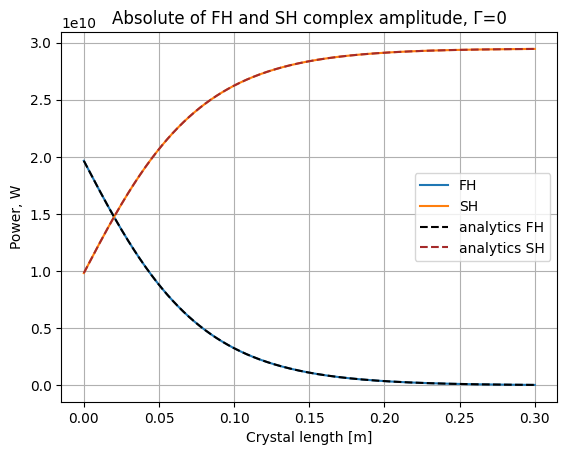

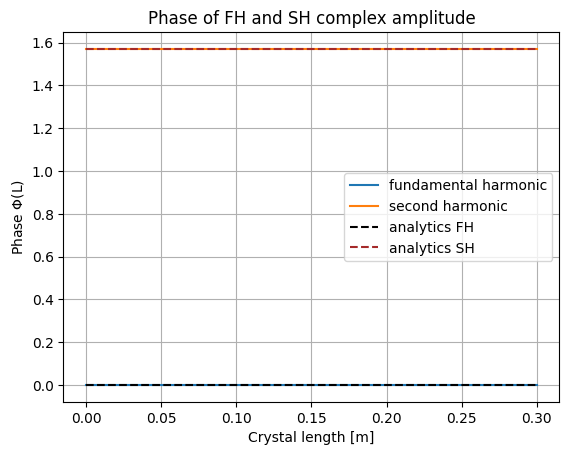

In [24]:
## Display results ###
#Amplitude
plt.figure()
plt.title("Absolute of FH and SH complex amplitude, Γ=0")
#plotting the numerical results for the amplitudes
plt.plot(L, np.abs(A1)**2, label = "FH") 
plt.plot(L, np.abs(A2)**2, label = "SH") 
#getting analytical solution (sn) for the general case of Γ

plt.plot(L, np.abs(A1_an)**2, label = "analytics FH", color='black', linestyle='--')
plt.plot(L, np.abs(A2_an)**2, label = "analytics SH", color='brown', linestyle='--')
if type=='dimensionless':
 
    plt.xlabel("Dimensionless crystal length")
    plt.xticks([1, 2,3], ["l", "2l",'3l'])  
    #plt.ylabel("normalized |A|^2")	
elif type=='dimensional':
    plt.xlabel("Crystal length [m]")
    #plt.ylabel("|A|^2")
    plt.ylabel('Power, W')	

plt.legend()
plt.grid()
plt.show()

#Phase
plt.figure()
plt.title("Phase of FH and SH complex amplitude")
plt.plot(L, np.angle(A1) , label = "fundamental harmonic")
plt.plot(L, np.angle(A2) , label = "second harmonic")
plt.plot(L, np.angle(A1_an), label = "analytics FH", color='black', linestyle='--')
plt.plot(L, np.angle(A2_an), label = "analytics SH", color='brown', linestyle='--')
if type=='dimensionless':
    plt.xlabel("Dimensionless crystal length")
    plt.xticks([1, 2,3], ["l", "2l", '3l'])  
else:
    plt.xlabel("Crystal length [m]")

plt.ylabel("Phase "+ r"$\Phi$" +"(L)")
plt.legend()
plt.grid()
plt.show()



## SHG and DOPA. $A^2(A_0^2)$ at fixed $L$.
### Seeing how the output amplitude of SH or FH depend on the input amplitude of FH recreating the plot from the all-optical ReLU article.
##### For that we start with having different amplitudes of the input SH and only two discrete values of $\Delta\phi=\pm\pi/2$

In [11]:
#Analytical
import time

P1_avg_0=1e-6
P2_avg_min, P2_avg_max = (0,8*P1_avg_0)
nP, nPhi=(50,2)
P2_avg_0_array=np.linspace(P2_avg_min,P2_avg_max, nP)
#all in all there are 18 combinations of delta fi from which only 9 different
phi2_0_array   = np.linspace(np.pi/7, np.pi/7, nPhi)
#initializing amplitudes and powers arrays
start=time.time()
A1_an = np.zeros((nP, nPhi), dtype = np.complex128)
A2_an = np.zeros((nP, nPhi), dtype = np.complex128)
P1_an = np.zeros((nP, nPhi))
P2_an = np.zeros((nP, nPhi))
#so we vary the phase of the SH beam and the power of the SH beam 
for i,P2_avg_0 in enumerate(P2_avg_0_array):
    for j,phi2_0 in enumerate(phi2_0_array):
            #analytics
            L, A1_an_, A2_an_, I1_an ,I2_an ,P1_an_ ,P2_an_ ,P1_avg_an_, P2_avg_an_ = analytics(P2_avg_0 = P2_avg_0, phi2_0 = phi2_0)
            #creating the array of amplitudes and powers where they contain only the A(L) values
            A1_an[i,j] = A1_an_
            A2_an[i,j] = A2_an_
            P1_an[i,j] = P1_avg_an_
            P2_an[i,j] = P2_avg_an_
            #Runge-Kutta
            
end = time.time()
print("Processing Time:", end - start, "s")
print("Time per Iteration:", (end - start)/(nP*nPhi),  's')


Processing Time: 0.05441641807556152 s
Time per Iteration: 0.0005441641807556152 s


C:\Users\kartashova\AppData\Local\Temp\ipykernel_8872\3646169034.py:101: RuntimeWarning: divide by zero encountered in divide
  return 1/(va2+(vb2-va2)*(sp.ellipj(np.sqrt(vc2-va2)*(z-sign*z0), gamma)[0])**2)
C:\Users\kartashova\AppData\Local\Temp\ipykernel_8872\3646169034.py:130: RuntimeWarning: invalid value encountered in scalar multiply
  phi2=phi2_0+u0**2*v0*np.cos(theta0)*integral_sh


In [12]:
#Runge-Kutta
import time

P1_avg_0=1e-6
P2_avg_min, P2_avg_max = (0,8*P1_avg_0)
nP, nPhi=(50,2)
P2_avg_0_array=np.linspace(P2_avg_min,P2_avg_max, nP)
#all in all there are 18 combinations of delta fi from which only 9 different
phi2_0_array   = np.linspace(np.pi/7, np.pi/7, nPhi)
#initializing amplitudes and powers arrays
start=time.time()
A1 = np.zeros((nP, nPhi), dtype = np.complex128)
A2 = np.zeros((nP, nPhi), dtype = np.complex128)
P1 = np.zeros((nP, nPhi))
P2 = np.zeros((nP, nPhi))
#so we vary the phase of the SH beam and the power of the SH beam 
for i,P2_avg_0 in enumerate(P2_avg_0_array):
    for j,phi2_0 in enumerate(phi2_0_array):
            L, A1_, A2_, I1 ,I2 ,P1_ ,P2_ ,P1_avg_, P2_avg_ = RungeKutta_SHG(P2_avg_0 = P2_avg_0, phi2_0 = phi2_0, crystal='bulk')
            #creating the array of amplitudes and powers where they contain only the A(L) values
            A1[i,j] = A1_[-1] 
            A2[i,j] = A2_[-1]
            P1[i,j] = P1_avg_[-1] 
            P2[i,j] = P2_avg_[-1]
end = time.time()
print("Processing Time:", end - start, "s")
print("Time per Iteration:", (end - start)/(nP*nPhi),  's')


Processing Time: 2.117142677307129 s
Time per Iteration: 0.021171426773071288 s


##### So the analytical one for obvious reasons (we dont have to calculate the amplitudes each step) is 100 times faster than Runge Kutta (and 10 times faster then whatever Marie was using). Works for any phase input now, cause we are using the general solution of Jacobi functions.

Results for SH_phase ( 0.14285714285714285 pi) - DOPA process in our case


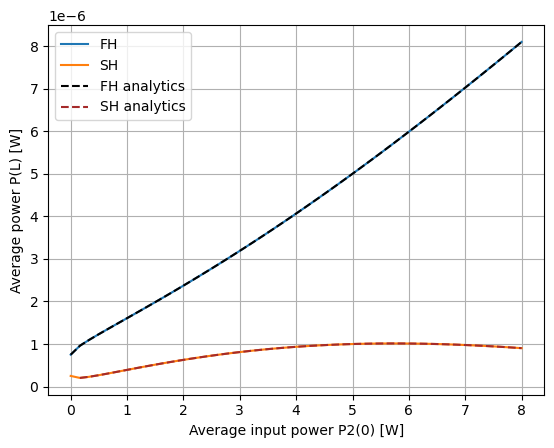

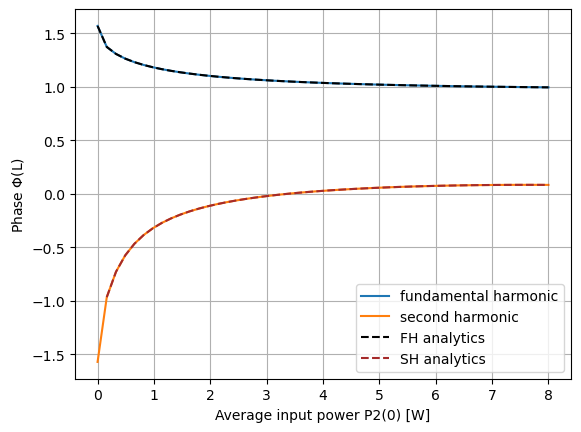

In [15]:
## Display results ###

# As an Example look at the output of the SH as a function of fixed input SH phase
x  = P2_avg_0_array/P1_avg_0
ind = 0

print("Results for SH_phase (", phi2_0_array[ind]/np.pi, "pi) - DOPA process in our case")

#Amplitude
plt.figure()
plt.plot(x, P1[:,ind], label = "FH") #Same as: np.real(A1)**2 +np.imag(A1)**2
plt.plot(x, P2[:,ind] , label = "SH") #Same as: np.real(A1)**2 +np.imag(A1)**2
plt.plot(x, P1_an[:,ind] , label = "FH analytics", linestyle='--', color='black') #Same as: np.real(A1)**2 +np.imag(A1)**2
plt.plot(x, P2_an[:,ind] , label = "SH analytics", linestyle='--', color='brown') #Same as: np.real(A1)**2 +np.imag(A1)**2
plt.xlabel("Average input power P2(0) [W]")
plt.ylabel("Average power P(L) [W]")
plt.legend()
plt.grid()
plt.show()

#Phase
plt.figure()
plt.plot(x, np.angle(A1[:,ind]) , label = "fundamental harmonic")
plt.plot(x, np.angle(A2[:,ind]) , label = "second harmonic")
plt.plot(x, np.angle(A1_an[:,ind]) , label = "FH analytics", linestyle='--', color='black') #Same as: np.real(A1)**2 +np.imag(A1)**2
plt.plot(x, np.angle(A2_an[:,ind]), label = "SH analytics", linestyle='--', color='brown')
plt.xlabel("Average input power P2(0) [W]")
plt.ylabel("Phase "+ r"$\Phi$" +"(L)")
plt.legend()
plt.grid()
plt.show()





## Now we only use analytics and build a bunch of graphs as Marie did, varying the FH power and phase

In [5]:
#HERE I VARY THE INPUT POWER OF THE FUNDAMENTAL HARMONIC AND SEE WHAT HAPPENS TO THE OUTPUT
import time
import warnings
nP = 50
nPhi = 2
P1_avg_0_array = np.linspace(0,8*1e-6,nP)
phi2_0_array   = np.linspace(-np.pi, np.pi, nPhi)
phi1_0_array   = [-np.pi, -3*np.pi/4, -np.pi/2,-np.pi/4, 0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi ]
#Array for saved Values
start = time.time()
A1 = np.zeros((nP, nPhi, len(phi1_0_array )), dtype = np.complex128)
A2 = np.zeros((nP, nPhi, len(phi1_0_array )), dtype = np.complex128)
P1 = np.zeros((nP, nPhi, len(phi1_0_array )))
P2 = np.zeros((nP, nPhi, len(phi1_0_array )))
for i,P1_avg_0 in enumerate(P1_avg_0_array):
    for j,phi2_0 in enumerate(phi2_0_array):
        for k,phi1_0 in enumerate(phi1_0_array): 
            #with warnings.catch_warnings(record=True) as w:
                #warnings.simplefilter("always", RuntimeWarning)  # Capture all RuntimeWarnings
            L, A1_, A2_, I1 ,I2 ,P1_ ,P2_ ,P1_avg_, P2_avg_ = analytics(P1_avg_0 = P1_avg_0, phi2_0 = phi2_0, phi1_0 = phi1_0)
            A1[i,j,k] = A1_
            A2[i,j,k] = A2_
            P1[i,j,k] = P1_avg_
            P2[i,j,k] = P2_avg_
                # If a RuntimeWarning occurred, print the value of x
                #if any(issubclass(warning.category, RuntimeWarning) for warning in w):
                    #print(f"RuntimeWarning occurred for P1_avg_0= {P1_avg_0}, phi2_0={phi2_0}, phi1_0={phi1_0}")

end = time.time()
print("Processing Time:", end - start)
print("Time per Iteration:", (end - start)/(nP*nPhi))

C:\Users\kartashova\AppData\Local\Temp\ipykernel_23536\2542209534.py:84: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  u=fsolve(equation, z0_guess)[0]


Processing Time: 0.39343953132629395
Time per Iteration: 0.003934395313262939


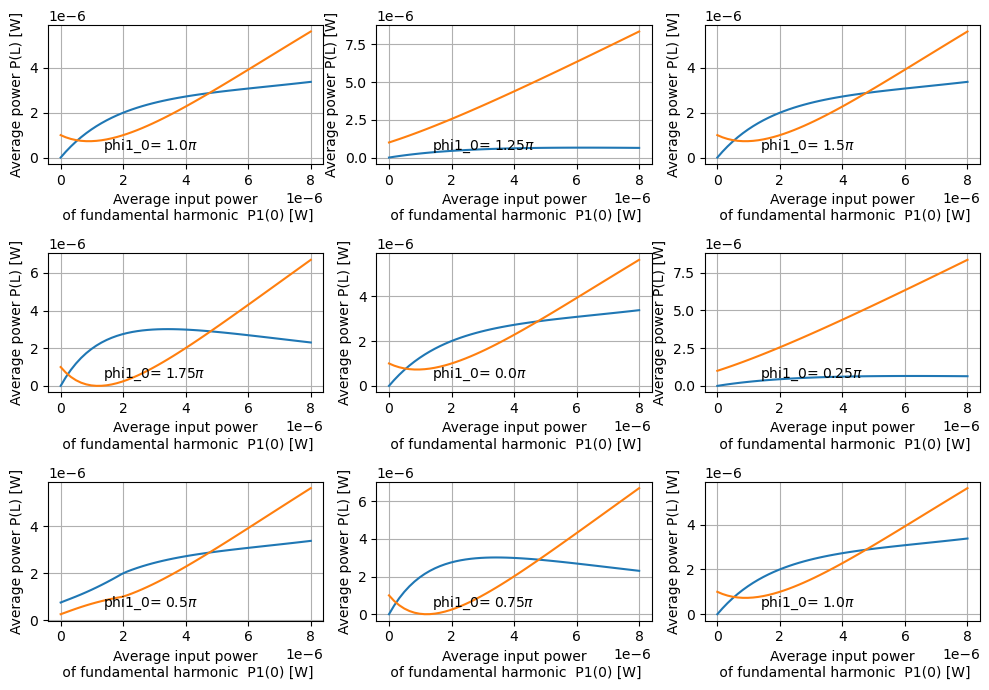

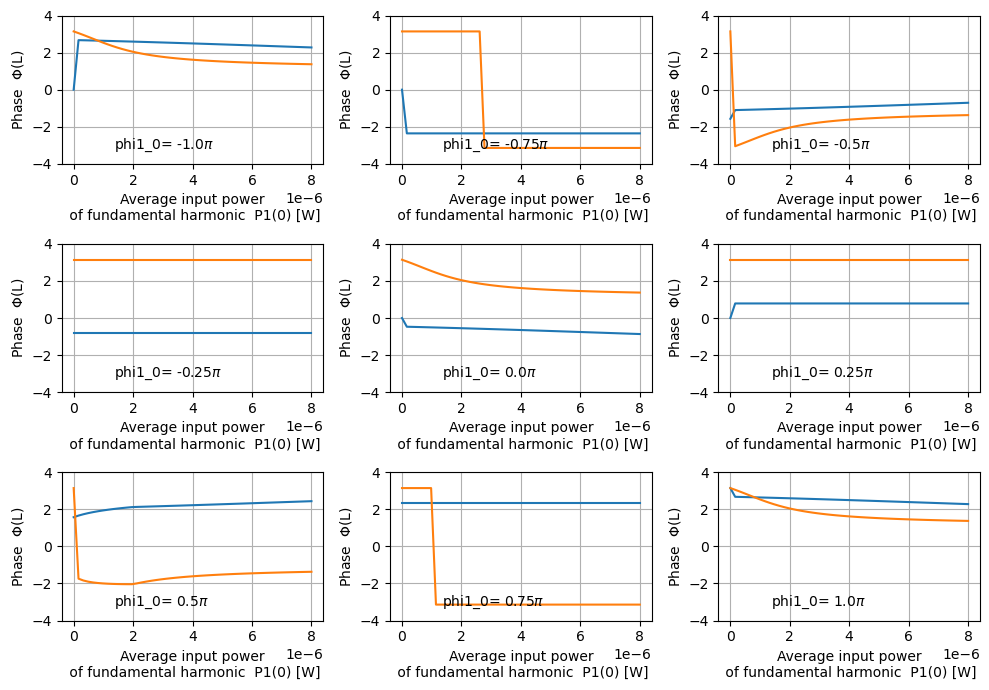

In [6]:
## Display results ###
# Here I choose one phase input for the second harmonic and plot the output for different FH input strength
x  = P1_avg_0_array

#Amplitude

fig, axs = plt.subplots(3,3, figsize = (10,7), tight_layout=True)
axs = axs.flat
for k,phi1_0 in enumerate(phi1_0_array): 
    y1 = np.squeeze(P1[:,1,k])
    y2 = np.squeeze(P2[:,1,k])
    axs[k].annotate("phi1_0= "+ str((phi1_0)%(2*phi2_0_array[1])/np.pi)+ r"$\pi$", xy = (0.2,0.1), xycoords = 'axes fraction') 
    axs[k].plot(x, y1 , label = "fundamental harmonic") 
    axs[k].plot(x, y2 , label = "second harmonic")
    axs[k].set_xlabel("Average input power\n of fundamental harmonic  P1(0) [W]")
    axs[k].set_ylabel("Average power P(L) [W]")
    #axs[k].legend()
    axs[k].grid()
plt.show()
plt.subplots_adjust(hspace=0.3)
plt.close()

#Phase
bbox = dict(boxstyle ="round", fc ="0.8") 
fig, axs = plt.subplots(3,3, figsize = (10,7), tight_layout=True)
axs = axs.flat
for k,phi1_0 in enumerate(phi1_0_array): 
    axs[k].annotate("phi1_0= "+ str(phi1_0/np.pi)+ r"$\pi$", xy = (0.2,0.1), xycoords = 'axes fraction') 
    axs[k].plot(x, np.angle(A1[:,1,k]) , label = "fundamental harmonic")
    axs[k].plot(x, np.angle(A2[:,1,k]) , label = "second harmonic")
    axs[k].set_xlabel("Average input power\n of fundamental harmonic  P1(0) [W]")
    axs[k].set_ylabel("Phase  " + r"$\Phi$"+ "(L)")
    axs[k].set_ylim(-4,4)

    #axs[k].legend()
    axs[k].grid()
plt.show()
plt.subplots_adjust(hspace=0.3)
plt.close()

###  Vary SH input Phase and Amplitude for otherwise fixed parameters

In [ ]:
#HERE I VARY THE INPUT POWER OF THE FUNDAMENTAL HARMONIC AND SEE WHAT HAPPENS TO THE OUTPUT
nP = 50
nPhi = 21
P1_avg_0 = 1e-6
P2_avg_min, P2_avg_max = (0,8*P1_avg_0)
P2_avg_0_array = np.linspace(P2_avg_min,P2_avg_max, nP )
phi2_0_array   = np.linspace(-np.pi, np.pi, nPhi)
phi1_0_array   = [-np.pi, -3*np.pi/4, -np.pi/2,-np.pi/4, 0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]

#Array for saved Values
start = time.time()
A1 = np.zeros((nP, nPhi, len(phi1_0_array )), dtype = np.complex128)
A2 = np.zeros((nP, nPhi, len(phi1_0_array )), dtype = np.complex128)
P1 = np.zeros((nP, nPhi, len(phi1_0_array )))
P2 = np.zeros((nP, nPhi, len(phi1_0_array )))
for i,P2_avg_0 in enumerate(P2_avg_0_array):
    for j,phi2_0 in enumerate(phi2_0_array):
        for k,phi1_0 in enumerate(phi1_0_array): 
            L, A1_, A2_, I1 ,I2 ,P1_ ,P2_ ,P1_avg_, P2_avg_= analytics(P1_avg_0 = P1_avg_0, P2_avg_0 = P2_avg_0, phi2_0 = phi2_0, phi1_0 = phi1_0)
            A1[i,j,k] = A1_
            A2[i,j,k] = A2_
            P1[i,j,k] = P1_avg_
            P2[i,j,k] = P2_avg_
            
            
end = time.time()
print("Processing Time:", end - start)
print("Time per Iteration:", (end - start)/(nP*nPhi))

C:\Users\kartashova\AppData\Local\Temp\ipykernel_13384\2370217813.py:102: RuntimeWarning: divide by zero encountered in divide
  return 1/(va2+(vb2-va2)*(sp.ellipj(np.sqrt(vc2-va2)*(z-sign*z0), gamma)[0])**2)
C:\Users\kartashova\AppData\Local\Temp\ipykernel_13384\2370217813.py:135: RuntimeWarning: invalid value encountered in scalar multiply
  phi2=phi2_0+u0**2*v0*np.cos(theta0)*integral_sh
C:\Users\kartashova\AppData\Local\Temp\ipykernel_13384\2370217813.py:84: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  u=fsolve(equation, z0_guess)[0]


Processing Time: 4.125851154327393
Time per Iteration: 0.003929382051740374


<>:27: SyntaxWarning: invalid escape sequence '\p'
<>:67: SyntaxWarning: invalid escape sequence '\p'
<>:106: SyntaxWarning: invalid escape sequence '\p'
<>:27: SyntaxWarning: invalid escape sequence '\p'
<>:67: SyntaxWarning: invalid escape sequence '\p'
<>:106: SyntaxWarning: invalid escape sequence '\p'
C:\Users\kartashova\AppData\Local\Temp\ipykernel_13384\3661518487.py:27: SyntaxWarning: invalid escape sequence '\p'
  '''bbox = dict(boxstyle ="round", fc ="0.8")
C:\Users\kartashova\AppData\Local\Temp\ipykernel_13384\3661518487.py:67: SyntaxWarning: invalid escape sequence '\p'
  '''bbox = dict(boxstyle ="round", fc ="0.8")
C:\Users\kartashova\AppData\Local\Temp\ipykernel_13384\3661518487.py:106: SyntaxWarning: invalid escape sequence '\p'
  '''bbox = dict(boxstyle ="round", fc ="0.8")


EXAMPLE for phi2=
0.0


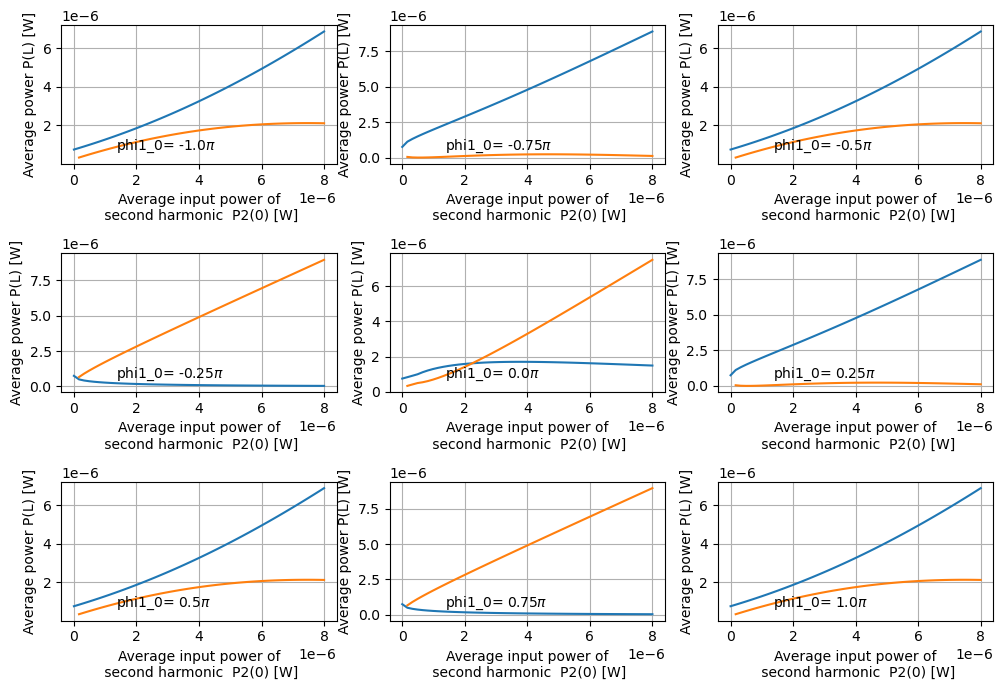

EXAMPLE for phi2=
-1.0


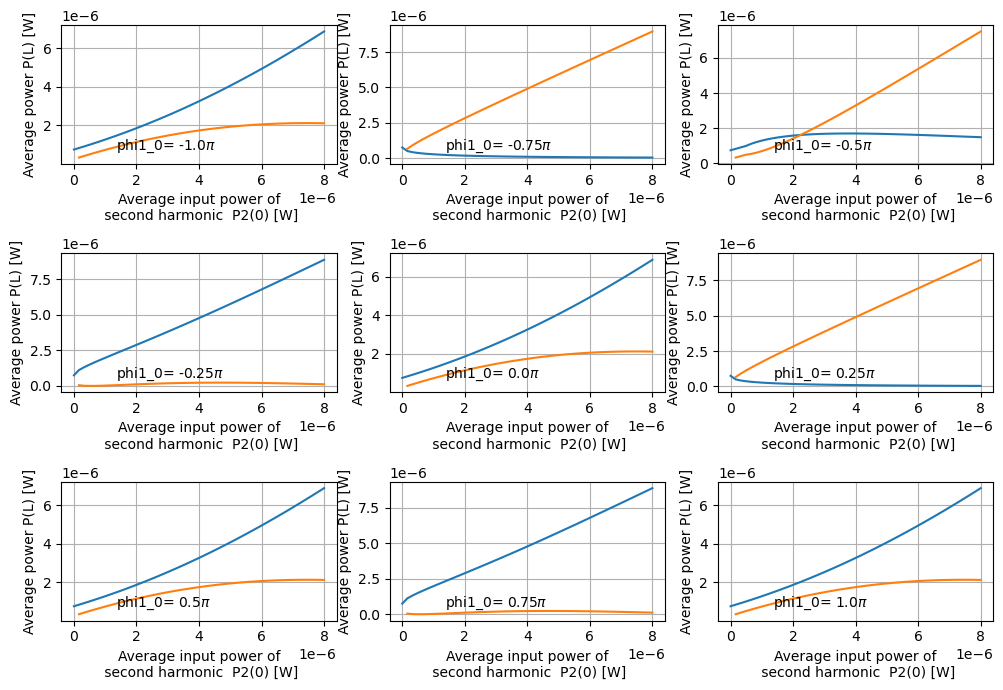

EXAMPLE for phi2=
-0.5


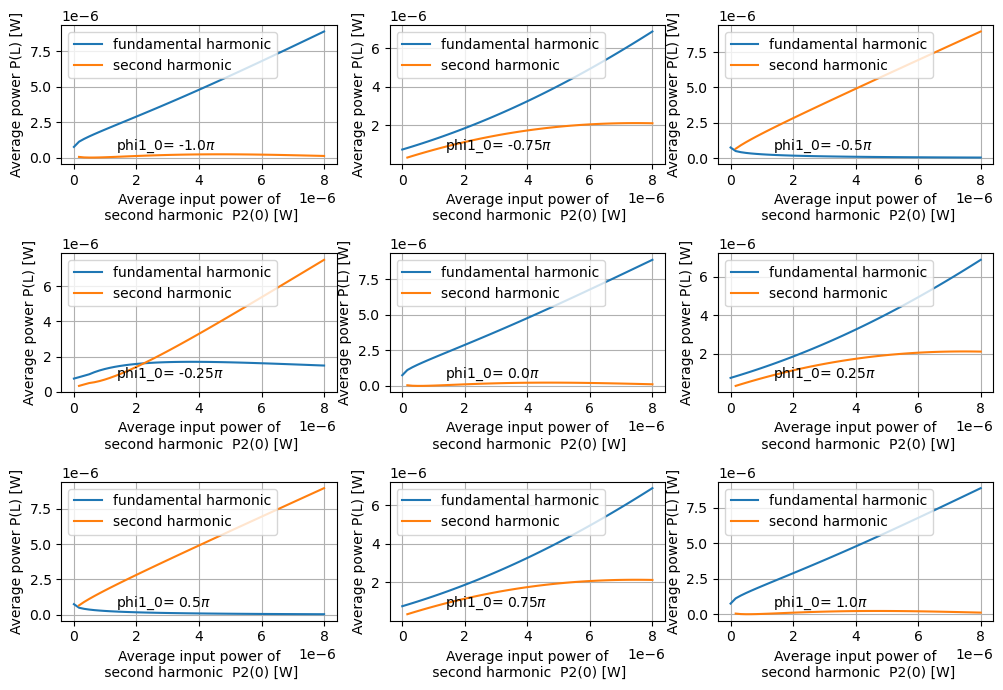

For the output the ratio of phi2 to phi1 is relevant or their difference... So By changing phi2 I can acess all values I could as when i would change phi1


In [63]:
## Display results ###
# Here I choose one phase input for the second harmonic and plot the output for different FH input strength
x  = P2_avg_0_array

ind = int(nPhi/2)
print("EXAMPLE for phi2=")
print(phi2_0_array[ind]/np.pi)

#Amplitude
fig, axs = plt.subplots(3,3, figsize = (10,7), tight_layout=True)
axs = axs.flat
for k,phi1_0 in enumerate(phi1_0_array): 
    y1 = np.squeeze(P1[:,ind,k])
    y2 = np.squeeze(P2[:,ind,k])
    axs[k].annotate("phi1_0= "+ str(phi1_0/np.pi)+ r"$\pi$", xy = (0.2,0.1), xycoords = 'axes fraction') 
    axs[k].plot(x, y1 , label = "fundamental harmonic") 
    axs[k].plot(x, y2 , label = "second harmonic")
    axs[k].set_xlabel("Average input power of\n second harmonic  P2(0) [W]")
    axs[k].set_ylabel("Average power P(L) [W]")
    #axs[k].legend()
    axs[k].grid()
plt.show()
plt.subplots_adjust(hspace=0.3)
plt.close()

#Phase
'''bbox = dict(boxstyle ="round", fc ="0.8") 
fig, axs = plt.subplots(3,3, figsize = (10,7), tight_layout=True)
axs = axs.flat
for k,phi1_0 in enumerate(phi1_0_array): 
    y1 = np.squeeze(A1[:,ind,k])
    y2 = np.squeeze(A2[:,ind,k])
    axs[k].annotate("phi1_0= "+ str(phi1_0/np.pi)+ r"$\pi$", xy = (0.2,0.1), xycoords = 'axes fraction') 
    axs[k].plot(x, np.angle(y1) , label = "fundamental harmonic")
    axs[k].plot(x, np.angle(y2) , label = "second harmonic")
    axs[k].set_xlabel("Input Power P1(0) of fundamental harmonic")
    axs[k].set_ylabel("Phase A(L)")
    #axs[k].legend()
    axs[k].grid()
plt.show()
plt.subplots_adjust(hspace=0.3)
plt.close()'''

ind = 0#int(nPhi/2)
print("EXAMPLE for phi2=")
print(phi2_0_array[ind]/np.pi)

#Amplitude
fig, axs = plt.subplots(3,3, figsize = (10,7), tight_layout=True)
axs = axs.flat
for k,phi1_0 in enumerate(phi1_0_array): 
    y1 = np.squeeze(P1[:,ind,k])
    y2 = np.squeeze(P2[:,ind,k])
    axs[k].annotate("phi1_0= "+ str(phi1_0/np.pi)+ r"$\pi$", xy = (0.2,0.1), xycoords = 'axes fraction') 
    axs[k].plot(x, y1 , label = "fundamental harmonic") 
    axs[k].plot(x, y2 , label = "second harmonic")
    axs[k].set_xlabel("Average input power of\n second harmonic  P2(0) [W]")
    axs[k].set_ylabel("Average power P(L) [W]")
    #axs[k].legend()
    axs[k].grid()
plt.show()
plt.subplots_adjust(hspace=0.3)
#plt.legend()
plt.close()

#Phase
'''bbox = dict(boxstyle ="round", fc ="0.8") 
fig, axs = plt.subplots(3,3, figsize = (10,7), tight_layout=True)
axs = axs.flat
for k,phi1_0 in enumerate(phi1_0_array): 
    y1 = np.squeeze(A1[:,ind,k])
    y2 = np.squeeze(A2[:,ind,k])
    axs[k].annotate("phi1_0= "+ str(phi1_0/np.pi)+ r"$\pi$", xy = (0.2,0.1), xycoords = 'axes fraction') 
    axs[k].plot(x, np.angle(y1) , label = "fundamental harmonic")
    axs[k].plot(x, np.angle(y2) , label = "second harmonic")
    axs[k].set_xlabel("Input Power P1(0) of fundamental harmonic")
    axs[k].set_ylabel("Phase A(L)")
    #axs[k].legend()
    axs[k].grid()
plt.show()
plt.subplots_adjust(hspace=0.3)
plt.close()
'''
ind = 5#int(nPhi/2)
print("EXAMPLE for phi2=")
print(phi2_0_array[ind]/np.pi)

#Amplitude
fig, axs = plt.subplots(3,3, figsize = (10,7), tight_layout=True)
axs = axs.flat
for k,phi1_0 in enumerate(phi1_0_array): 
    y1 = np.squeeze(P1[:,ind,k])
    y2 = np.squeeze(P2[:,ind,k])
    axs[k].annotate("phi1_0= "+ str(phi1_0/np.pi)+ r"$\pi$", xy = (0.2,0.1), xycoords = 'axes fraction') 
    axs[k].plot(x, y1 , label = "fundamental harmonic") 
    axs[k].plot(x, y2 , label = "second harmonic")
    axs[k].set_xlabel("Average input power of\n second harmonic  P2(0) [W]")
    axs[k].set_ylabel("Average power P(L) [W]")
    axs[k].legend()
    axs[k].grid()
plt.show()
plt.subplots_adjust(hspace=0.3)
plt.close()

#Phase
'''bbox = dict(boxstyle ="round", fc ="0.8") 
fig, axs = plt.subplots(3,3, figsize = (10,7), tight_layout=True)
axs = axs.flat
for k,phi1_0 in enumerate(phi1_0_array): 
    y1 = np.squeeze(A1[:,ind,k])
    y2 = np.squeeze(A2[:,ind,k])
    axs[k].annotate("phi1_0= "+ str(phi1_0/np.pi)+ r"$\pi$", xy = (0.2,0.1), xycoords = 'axes fraction') 
    axs[k].plot(x, np.angle(y1) , label = "fundamental harmonic")
    axs[k].plot(x, np.angle(y2) , label = "second harmonic")
    axs[k].set_xlabel("Input Power P1(0) of fundamental harmonic")
    axs[k].set_ylabel("Phase A(L)")
    #axs[k].legend()
    axs[k].grid()
plt.show()
plt.subplots_adjust(hspace=0.3)
plt.close()
'''

print("For the output the ratio of phi2 to phi1 is relevant or their difference... So By changing phi2 I can acess all values I could as when i would change phi1")

In [65]:
#HERE I VARY THE INPUT POWER OF THE FUNDAMENTAL HARMONIC AND SEE WHAT HAPPENS TO THE OUTPUT
nP = 50
nPhi = 41
P1_avg_0 = 1e-6
P2_avg_min, P2_avg_max = (0,8*P1_avg_0)
P2_avg_0_array = np.linspace(P2_avg_min,P2_avg_max, nP )
phi2_0_array   = np.linspace(0, np.pi, nPhi)

#Array for saved Values
start = time.time()
A1 = np.zeros((nP, nPhi), dtype = np.complex128)
A2 = np.zeros((nP, nPhi), dtype = np.complex128)
P1 = np.zeros((nP, nPhi))
P2 = np.zeros((nP, nPhi))
for i,P2_avg_0 in enumerate(P2_avg_0_array):
    for j,phi2_0 in enumerate(phi2_0_array):
            L, A1_, A2_, I1 ,I2 ,P1_ ,P2_ ,P1_avg_, P2_avg= analytics(P1_avg_0 = 1e-6, P2_avg_0 = P2_avg_0, phi2_0 = phi2_0, phi1_0 = phi1_0)
            A1[i,j] = A1_
            A2[i,j] = A2_
            P1[i,j] = P1_avg_
            P2[i,j] = P2_avg_
            
end = time.time()
print("Processing Time:", end - start)
print("Time per Iteration:", (end - start)/(nP*nPhi))

C:\Users\kartashova\AppData\Local\Temp\ipykernel_13384\2370217813.py:102: RuntimeWarning: divide by zero encountered in divide
  return 1/(va2+(vb2-va2)*(sp.ellipj(np.sqrt(vc2-va2)*(z-sign*z0), gamma)[0])**2)
C:\Users\kartashova\AppData\Local\Temp\ipykernel_13384\2370217813.py:135: RuntimeWarning: invalid value encountered in scalar multiply
  phi2=phi2_0+u0**2*v0*np.cos(theta0)*integral_sh
C:\Users\kartashova\AppData\Local\Temp\ipykernel_13384\2370217813.py:84: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  u=fsolve(equation, z0_guess)[0]


Processing Time: 0.9013803005218506
Time per Iteration: 0.00043969770757163444


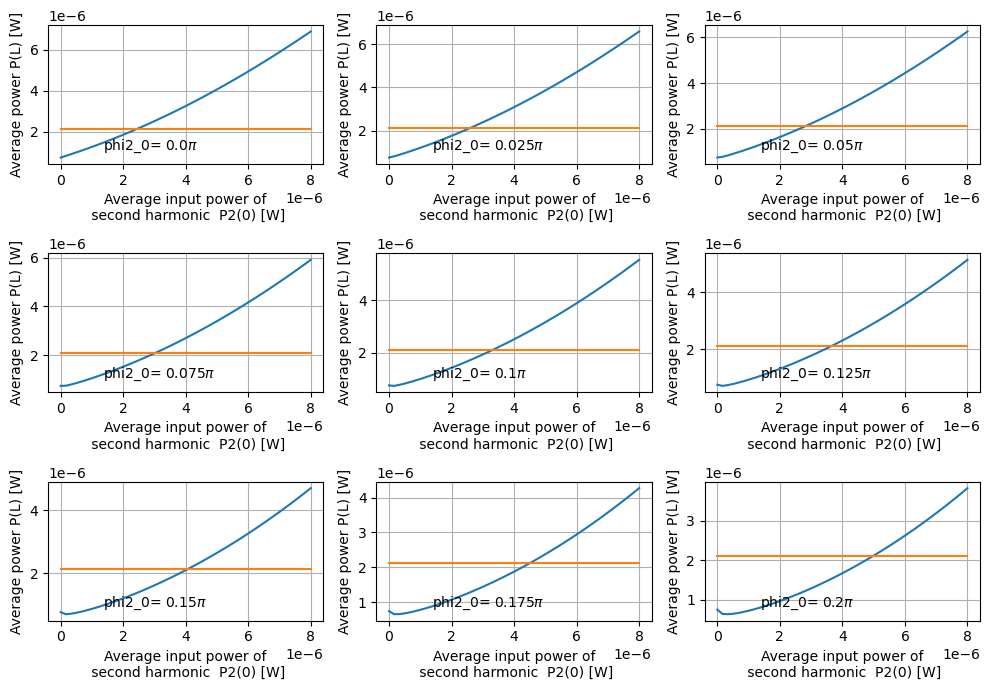

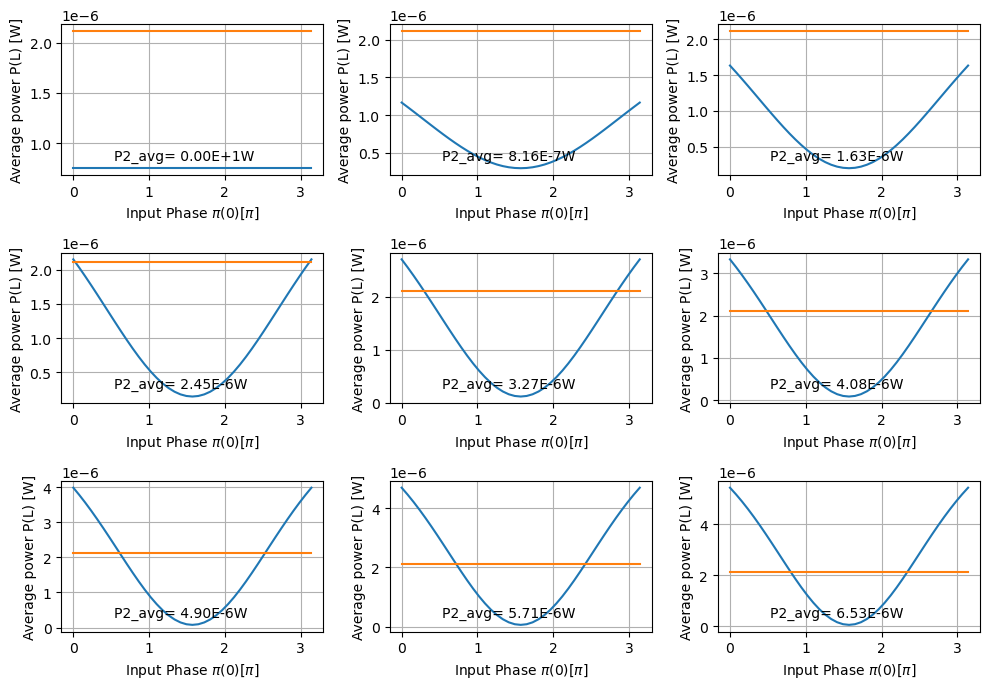

In [66]:
#Amplitude
x = P2_avg_0_array 
fig, axs = plt.subplots(3,3, figsize = (10,7), tight_layout=True)
axs = axs.flat
for k,phi2_0 in enumerate(phi2_0_array): 
    if k ==9:
        break
    y1 = np.squeeze(P1[:,k])
    y2 = np.squeeze(P2[:,k])
    axs[k].annotate("phi2_0= "+ str(phi2_0/np.pi)+ r"$\pi$", xy = (0.2,0.1), xycoords = 'axes fraction') 
    axs[k].plot(x, y1 , label = "fundamental harmonic") 
    axs[k].plot(x, y2 , label = "second harmonic")
    axs[k].set_xlabel("Average input power of\n second harmonic  P2(0) [W]")
    axs[k].set_ylabel("Average power P(L) [W]")
    #axs[k].legend()
    axs[k].grid()
plt.show()
plt.subplots_adjust(hspace=0.3)
plt.close()

#Amplitude
from decimal import Decimal
#f"{Decimal('40800000000.00000000000000'):.2E}"
x = phi2_0_array
fig, axs = plt.subplots(3,3, figsize = (10,7), tight_layout=True)
axs = axs.flat
for k,P2_avg_0 in enumerate(P2_avg_0_array): 
    if k ==9:
        break
    val = P2_avg_0_array[k*5]
    y1 = np.squeeze(P1[k*5,:])
    y2 = np.squeeze(P2[k*5,:])
    axs[k].annotate("P2_avg= "+ "{:.2E}".format(Decimal(str(val))) +"W", xy = (0.2,0.1), xycoords = 'axes fraction') 
    axs[k].plot(x, y1 , label = "fundamental harmonic") 
    axs[k].plot(x, y2 , label = "second harmonic")
    axs[k].set_ylabel("Average power P(L) [W]")
    axs[k].set_xlabel("Input Phase " + r"$\pi$" + "(0)" + "[" + r"$\pi$" + "]")
    #axs[k].legend()
    axs[k].grid()
plt.show()
plt.subplots_adjust(hspace=0.3)
plt.close()

### Power dependance on the input phase difference

In [295]:
#Analytical
import time

P1_avg_0=1e-6
P2_avg_0=1e-6
phi1_0=np.pi/2

phi2_0_min, phi2_0_max = (-np.pi,np.pi)
nPhi=(50)
phi2_0_array=np.linspace(phi2_0_min, phi2_0_max)

#initializing amplitudes and powers arrays
start=time.time()
A1_an = np.zeros((nPhi), dtype = np.complex128)
A2_an = np.zeros((nPhi), dtype = np.complex128)
P1_an = np.zeros(( nPhi))
P2_an = np.zeros((nPhi))
#so we vary the phase of the SH beam and the power of the SH beam 
for j,phi2_0 in enumerate(phi2_0_array):
    #analytics
    L, A1_an_, A2_an_, I1_an ,I2_an ,P1_an_ ,P2_an_ ,P1_avg_an_, P2_avg_an_ = analytics(P2_avg_0 = P2_avg_0, phi2_0 = phi2_0, phi1_0=phi1_0)
    #creating the array of amplitudes and powers where they contain only the A(L) values
    A1_an[j] = A1_an_
    A2_an[j] = A2_an_
    P1_an[j] = P1_avg_an_
    P2_an[j] = P2_avg_an_
        
end = time.time()
print("Processing Time:", end - start, "s")
print("Time per Iteration:", (end - start)/(nP*nPhi),  's')


Processing Time: 0.026641130447387695 s
Time per Iteration: 1.0656452178955077e-05 s


In [291]:
#Runge-Kutta
import time

P1_avg_0=1e-6
P2_avg_0=1e-6
phi2_0_min, phi2_0_max = (-np.pi,np.pi)
nPhi=(50)
phi2_0_array=np.linspace(phi2_0_min, phi2_0_max)
#all in all there are 18 combinations of delta fi from which only 9 different
#initializing amplitudes and powers arrays
start=time.time()
A1 = np.zeros((nPhi), dtype = np.complex128)
A2= np.zeros((nPhi), dtype = np.complex128)
P1 = np.zeros(( nPhi))
P2 = np.zeros((nPhi))
#so we vary the phase of the SH beam and the power of the SH beam 
for j,phi2_0 in enumerate(phi2_0_array):
    #analytics
    L, A1_, A2_, I1_ ,I2_ ,P1_ ,P2_ ,P1_avg_, P2_avg_ = RungeKutta_SHG(P2_avg_0 = P2_avg_0, phi2_0 = phi2_0, phi1_0=phi1_0)
    #creating the array of amplitudes and powers where they contain only the A(L) values
    A1[j] = A1_[-1]
    A2[j] = A2_[-1]
    P1[j] = P1_avg_[-1]
    P2[j] = P2_avg_[-1]
        
end = time.time()
print("Processing Time:", end - start, "s")
print("Time per Iteration:", (end - start)/(nP*nPhi),  's')


Processing Time: 1.1571109294891357 s
Time per Iteration: 0.0004628443717956543 s


Results for SH_phase ( -1.0 pi) - DOPA process in our case


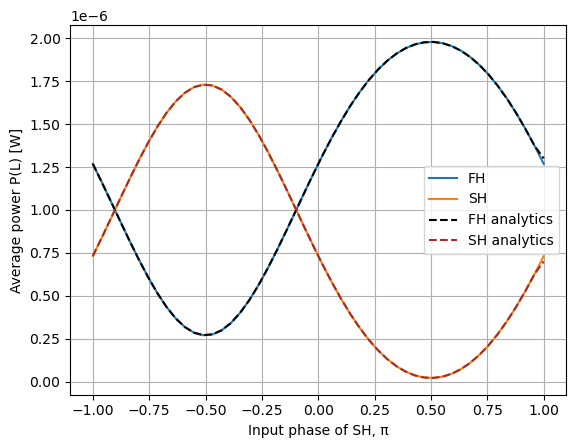

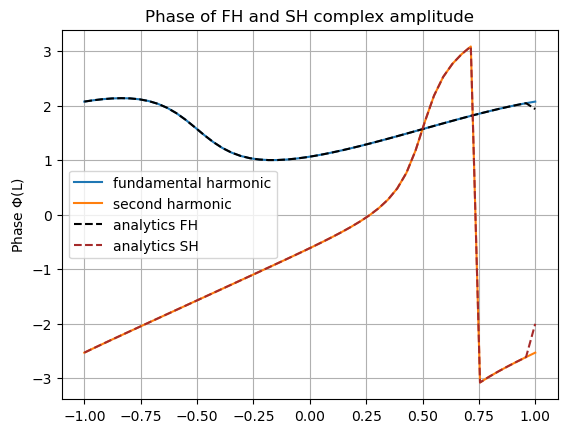

In [281]:
## Display results ###

# As an Example look at the output of the SH as a function of fixed input SH phase
x  = phi2_0_array/np.pi
ind = 0

print("Results for SH_phase (", phi2_0_array[ind]/np.pi, "pi) - DOPA process in our case")

#Amplitude
plt.figure()
plt.plot(x, P1, label = "FH") #Same as: np.real(A1)**2 +np.imag(A1)**2
plt.plot(x, P2 , label = "SH") #Same as: np.real(A1)**2 +np.imag(A1)**2
plt.plot(x, P1_an , label = "FH analytics", linestyle='--', color='black') #Same as: np.real(A1)**2 +np.imag(A1)**2
plt.plot(x, P2_an , label = "SH analytics", linestyle='--', color='brown') #Same as: np.real(A1)**2 +np.imag(A1)**2
plt.xlabel("Input phase of SH, π")
plt.ylabel("Average power P(L) [W]")
plt.legend()
plt.grid()
plt.show()

#Phase
plt.figure()
plt.title("Phase of FH and SH complex amplitude")
plt.plot(x, np.angle(A1) , label = "fundamental harmonic")
plt.plot(x, np.angle(A2) , label = "second harmonic")
plt.plot(x, np.angle(A1_an), label = "analytics FH", color='black', linestyle='--')
plt.plot(x, np.angle(A2_an), label = "analytics SH", color='brown', linestyle='--')

plt.ylabel("Phase "+ r"$\Phi$" +"(L)")
plt.xlabel("Input phase of SH, π")

plt.legend()
plt.grid()
plt.show()



### Remark
#### The result is inverted compared to the article exactly for the reason that they set their condition for having SHG reversed to how Boyd did it. In principle thought, there is no difference. 

In [ ]:
#the question is: do we want to vary the SH input or FH input amplitude? which is easier 

# Convergence test 

### for numerically finding $\int_0^{\zeta}\frac{d\zeta}{u_a^2+(u_b^2-u_a^2)sn^2(\sqrt{u_c^2-u_a^2}(\zeta\mp C), \gamma)}$

In [305]:
def integral(N=1000, P1_avg_0=1e-6, P2_avg_0=1e-6,phi1_0=np.pi/2, phi2_0=np.pi, lam1=1.064e-6,
            n1=2.1, n2=2.1, d_eff=(20e-12)*(2/np.pi),
            T_p = 30e-12, R_p =  1e3, L=10e-3):
    def equation(u):
        return sp.ellipj(u, gamma)[0] - sn_value_0  # Extract the sn(u, m) value
    
    c=3e8                       #speed of light in m/s
    epsilon_0=8.854187817e-12   #vacuum permittivity in F/m
    P1_0     = P1_avg_0/(T_p*R_p) #input peak power for the FH [W]
    P2_0     = P2_avg_0/(T_p*R_p) #input peak power for the SH [W]
    omega1   = 2*np.pi*c/lam1 #frequency of FH [s]
    omega2   = 2*omega1 #frequency of SH [s]
    w_0   = np.sqrt((L*(lam1/n1))/(2*np.pi)) #waist radius of the Gaussian beam
    S_eff = np.pi*(np.sqrt(2)*w_0)**2 #effective area of the collimated beam in the crystal in units of m**2
    
    z= L 

    A1_0 = np.sqrt(P1_0/(2*n1*c*epsilon_0*S_eff))*np.exp(1j*phi1_0) 
    A2_0 = np.sqrt(P2_0/(2*n2*c*epsilon_0*S_eff))*np.exp(1j*phi2_0) 
    I1_0  = P1_0/S_eff
    I2_0  = P2_0/S_eff
    
    k1       = n1*omega1/c
    k2       = n2*omega2/c
    if 2*k1-k2!=0:  #should alway be zero otherwise the analytics doesn't work
        print('Analytics cannot be found as Δk!=0')
        return 

    # Normalization factors for the amplitude and the distance (from Boyd)
    factor_1=np.sqrt((P1_0*n2+P2_0*n1)/(2*n1*n2*c*epsilon_0*S_eff)) 
    l=np.sqrt(2*n1**2*n2*epsilon_0*c/(I1_0+I2_0))*c/(2*omega1*d_eff)
    
    #because the analytical solution is dimensionless, we normalize all the input values
    u0=np.abs(A1_0)/factor_1
    v0=np.abs(A2_0)/factor_1
    z=z/l
    #constants for our analytical solution
    Gamma=u0**2*v0*np.cos(2*phi1_0-phi2_0)
    sign=np.sign(np.sin(2*phi1_0-phi2_0)) #this sign determines the sign of the integration constant z0
    
    #finding roots of the third order polynomial equation on the right side of the differential equation
    coeffs=[1, -2,1,-Gamma**2]
    roots=np.roots(coeffs)
    va2, vb2, vc2 = np.real(np.sort(roots))
    gamma=(vb2-va2)/(vc2-va2)
    
    #getting constants of integration
    sn_value_0=np.sqrt((v0**2-va2)/(vb2-va2))
    z0_guess=1.
    u=fsolve(equation, z0_guess)[0]
    z0=1/np.sqrt(vc2-va2)*u

    theta0=2*phi1_0-phi2_0

    def func_sh(z):
        return 1/(va2+(vb2-va2)*(sp.ellipj(np.sqrt(vc2-va2)*(z-sign*z0), gamma)[0])**2)
    def func_fh(z):
        return 1/(1-va2-(vb2-va2)*(sp.ellipj(np.sqrt(vc2-va2)*(z-sign*z0), gamma)[0])**2 )

    x_values = np.linspace(0, L, N)
    y_sh=func_sh(x_values)
    y_fh=func_fh(x_values)
    integral_fh = np.trapz(y_fh, x_values)
    integral_sh = np.trapz(y_sh, x_values)
    phi1=phi1_0+u0**2*v0*np.cos(theta0)*integral_fh
    #theta=np.arccos(u0**2*v0*np.cos(theta0)/(u2*v))
    #phi2=2*phi1-theta
    phi2=phi2_0+u0**2*v0*np.cos(theta0)*integral_sh
    
    return phi1, phi2

Processing Time: for N= 25 is 0.0000000000 .10f
Processing Time: for N= 50 is 0.0000000000 .10f
Processing Time: for N= 100 is 0.0000000000 .10f
Processing Time: for N= 200 is 0.0000000000 .10f
Processing Time: for N= 300 is 0.0000000000 .10f
Processing Time: for N= 400 is 0.0074818134 .10f
Processing Time: for N= 500 is 0.0000000000 .10f
Processing Time: for N= 600 is 0.0019936562 .10f


Text(0, 0.5, 'Relative error, %')

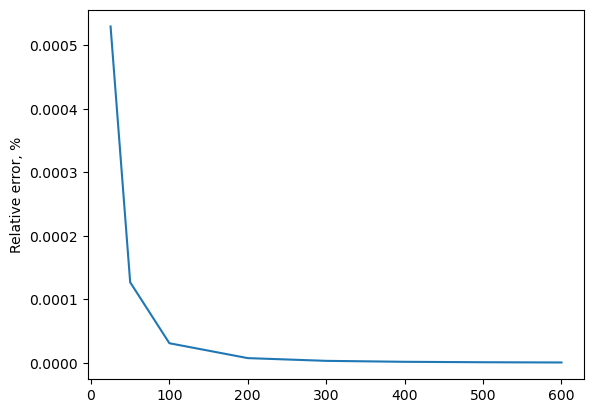

In [333]:
L=300e-3
N=1000
P1_avg_0=1e-6  
P2_avg_0=1e-6
phi1_0=np.pi/2
phi2_0=-np.pi/7
reference_phi1, reference_phi2=integral(N=N, P1_avg_0=P1_avg_0, P2_avg_0=P2_avg_0,phi1_0=phi1_0, phi2_0=phi2_0, L=L)


N_array=np.array((25, 50, 100, 200, 300, 400, 500, 600))
phi1_array=np.zeros((N_array.shape[0]))
phi2_array=np.zeros((N_array.shape[0]))

for i,N in enumerate(N_array):
    start = time.time()
    phi1, phi2=integral(N=N, P1_avg_0=P1_avg_0, P2_avg_0=P2_avg_0,phi1_0=phi1_0, phi2_0=phi2_0, L=L)
    phi1_array[i]=phi1
    phi2_array[i]=phi2
    end = time.time()
    formatted_time = format(end-start, ".10f")
    print("Processing Time: for N=", N, 'is', formatted_time, ".10f")

plt.figure()
plt.plot(N_array, np.abs(phi2_array-reference_phi2)/np.abs(reference_phi2)*100, label='phi2')
plt.ylabel('Relative error, %')


#### Seems like maybe even 50 points should be enough, 100 to be safe

# Jacobi elliptical functions. Examples

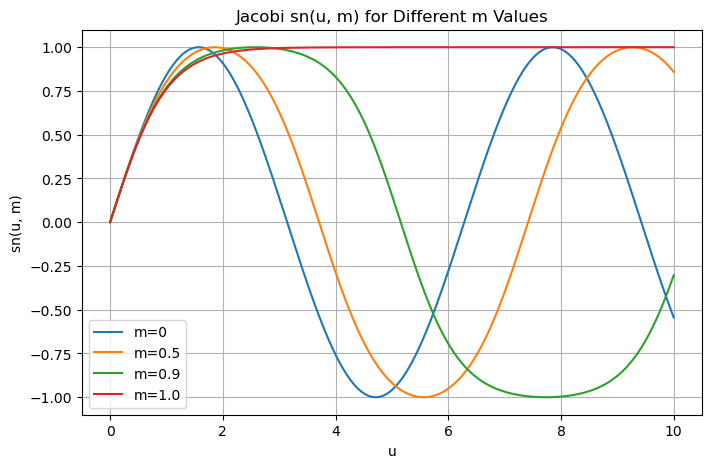

In [316]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import ellipj

u = np.linspace(0, 10, 1000)
m_values = [0, 0.5, 0.9, 1.0]

plt.figure(figsize=(8, 5))
for m in m_values:
    sn, cn, dn, _ = ellipj(u, m)
    plt.plot(u, sn, label=f"m={m}")

plt.legend()
plt.title("Jacobi sn(u, m) for Different m Values")
plt.xlabel("u")
plt.ylabel("sn(u, m)")
plt.grid()
plt.show()


In [ ]:
#ATTEMPTS DO FIND PHASES ANALYTICALLY
def integral_sh(L):
        from scipy.special import ellipe, ellipk, ellipeinc, ellipkinc
        alpha2=-(vb2-va2)/va2
        Kappa=L/(np.sqrt(vc2-va2))
        gamma_ap=np.sqrt(1-gamma**2)
        psi=np.arcsin(np.sqrt(alpha2/(alpha2-gamma**2)))
        Lambda_function=2/np.pi*(ellipe(gamma)*ellipkinc(psi, gamma_ap)+Kappa*ellipeinc(psi,gamma_ap)-Kappa*ellipkinc(psi,gamma_ap))
        integral=1/(va2*np.sqrt(vc2-va2))*(gamma**2*Kappa/(gamma**2-alpha2)-np.pi*alpha2*Lambda_function/(2*np.sqrt(alpha2*(1-alpha2)*(alpha2-gamma**2))))
        return integral
    
    def integral_fh(L):
        from scipy.special import ellipe, ellipk, ellipeinc, ellipkinc
        import mpmath as mp
        #constants and special variables
        alpha2=(vb2-va2)/(1-va2)
        alpha=np.sqrt(alpha2)
        gamma_ap=np.sqrt(1-gamma**2)
        preInt=1/(1-va2)*1/np.sqrt(vc2-va2)
        #special functions
        Kappa=ellipk(gamma)
        Kappa_ap=ellipk(gamma_ap)
        
        beta=np.arcsin(np.sqrt((1-alpha**2)/gamma_ap**2))
        Lambda0=2/np.pi*(ellipe(gamma)*ellipkinc(beta, gamma_ap)+Kappa*ellipeinc(beta, gamma_ap)-Kappa*ellipkinc(beta, gamma_ap))
        vau=np.pi*L/(2*Kappa)
        wau=np.pi*ellipkinc(beta, gamma_ap)/(2*Kappa)
        q=np.exp(-np.pi*Kappa_ap/Kappa)
        Sigma2=1j*Kappa/np.pi*mp.log(mp.jtheta(2, vau+i*wau, q)/mp.jtheta(2, vau-i*wau, q))
        integral=preInt*(L+(np.pi*alpha*(Sigma2-L*Lambda0))/(2*np.sqrt((alpha2-gamma**2)*(1-alpha2))*Kappa))
        return integral
    
    if isinstance(z, np.ndarray):
        for i,l in enumerate(z):
            if i==0:
                c02=phi2_0-u0**2*v0*np.cos(theta0)*integral_sh(l)
                c01=phi1_0-u0**2*v0*np.cos(theta0)*integral_fh(l)
            phi1_value=c01+u0**2*v0*np.cos(theta0)*integral_fh(l)
            phi2_value=c02+u0**2*v0*np.cos(theta0)*integral_sh(l)
            print(phi1_value)
            phi1[i]=np.real(phi1_value)
            phi2[i]=-phi2_value

## Input already only with amplitudes

In [36]:
import scipy.special as sp
from scipy.optimize import fsolve
def analytics(input_FH, input_SH, lam1=1.064e-6,
            n1=2.1, n2=2.1, d_eff=(20e-12)*(2/np.pi),
             L=10e-3, N_z=1000):
    """ 
    Parameters:
    input_FH[complex64]: input value of the fundamental harmonic
    input_SH[complex64]: input value of the second  harmonic
    lam[float]     : FH wavelength in units of m
    L[float]        : total crystal length in units of m
    n1[float]       : refractive index of the material at the FH wavelength
    n2 [float]      : refractive index of the material at the SH wavelength, if n2 = n1 the system is phasematched
    d_eff[float]    : effective nonlinearity in units of m/V, look at boyd eq (2.4.3) for effective d with QPM
    N_z[int]        : number of sampling points
    
    Returns:
    output_FH[complex64]: output value of the fundamental harmonic

    Function implements the analytical solution of the coupled
    mode equations for SHG in a bulk crystal. The solution is based on the elliptic
    Jacobi function and is taken from https://doi.org/10.1103/PhysRev.127.1918. 
    This solution is valid for any phase mismatch for the input beams 
    as long as Δk=0.

    """
    def equation(u):
        return sp.ellipj(u, gamma)[0] - sn_value_0  # Extract the sn(u, m) value
    #constants
    c=3e8                       #speed of light in m/s
    epsilon_0=8.854187817e-12   #vacuum permittivity in F/m
    omega1   = 2*np.pi*c/lam1 #frequency of FH [s]
    omega2   = 2*omega1 #frequency of SH [s]
    

    #z= L
    # 
    dz    = L/(N_z-1)
    z  = np.linspace(0,L, N_z)
    
    u0=np.abs(input_FH)
    print(u0)
    v0=np.abs(input_SH)
    phi1_0=np.angle(input_FH)
    phi2_0=np.angle(input_SH)
    
    
    k1       = n1*omega1/c
    k2       = n2*omega2/c
    if 2*k1-k2!=0:  #should alway be zero otherwise the analytics doesn't work
        print('Analytics cannot be found because Δk!=0')
        return 

    
    #constants for our analytical solution
    Gamma=u0**2*v0*np.cos(2*phi1_0-phi2_0)
    sign=np.sign(np.sin(2*phi1_0-phi2_0)) #this sign determines the sign of the integration constant z0
    
    #finding roots of the third order polynomial equation on the right side of the differential equation
    coeffs=[1, -2,1,-Gamma**2]
    roots=np.roots(coeffs)
    va2, vb2, vc2 = np.round(np.real(np.sort(roots)), 14)
    gamma=(vb2-va2)/(vc2-va2)
    #getting constants of integration
    if np.round(v0**2,6)==np.round(va2,6):
        va2=v0**2
    sn_value_0=np.sqrt((v0**2-va2)/(vb2-va2))
    z0_guess=1.
    u=fsolve(equation, z0_guess)[0]
    z0=1/np.sqrt(vc2-va2)*u

    #the analytical solution for amplitudes
    v2=va2+(vb2-va2)*(sp.ellipj(np.sqrt(vc2-va2)*(z-sign*z0), gamma)[0])**2 #amplitude squared of SH
    u2=1-v2
   
    u=np.sqrt(u2)
    v=np.sqrt(v2)
    print(u[1], v[1])
    theta0=2*phi1_0-phi2_0

    #SHG for theta0=3pi/2
    #phi1=phi1_0+0.5*u0**2*v0*np.cos(theta0)*(z-sign*z0+np.cosh(z-sign*z0)*np.sinh(z-sign*z0)+sign*z0-np.cosh(-sign*z0)*np.sinh(-sign*z0))
    #phi2=phi2_0+u0**2*v0*np.cos(theta0)*(z-sign*z0-np.cosh(z-sign*z0)/np.sinh(z-sign*z0)+sign*z0+np.cosh(-sign*z0)/np.sinh(-sign*z0))
    #print(phi1_0, phi2_0, phi1[0], phi2[0], z[0])

    #general case of theta
    def func_sh(z):
        return 1/(va2+(vb2-va2)*(sp.ellipj(np.sqrt(vc2-va2)*(z-sign*z0), gamma)[0])**2)
    def func_fh(z):
        return 1/(1-va2-(vb2-va2)*(sp.ellipj(np.sqrt(vc2-va2)*(z-sign*z0), gamma)[0])**2 )
    
    
    if isinstance(z, np.ndarray):
        phi1=np.zeros_like(u)
        phi2=np.zeros_like(v) 
        for i,l in enumerate(z):
            
            #phi1_value=c01+u0**2*v0*np.cos(theta0)*integral_fh(l)
            x_values = np.linspace(0, l, 200)
            y_sh=func_sh(x_values)
            y_fh=func_fh(x_values)
            integral_fh = np.trapz(y_fh, x_values)
            integral_sh = np.trapz(y_sh, x_values)
            if (np.cos(theta0)==0) or (u0==0) or (v0==0):
                phi1_value=phi1_0   
                phi2_value=phi2_0   
            else:
                phi1_value=phi1_0+u0**2*v0*np.cos(theta0)*integral_fh
                phi2_value=phi2_0+u0**2*v0*np.cos(theta0)*integral_sh
            phi1[i]=phi1_value
            phi2[i]=phi2_value
    else:
        l=z
        x_values = np.linspace(0, l, 200)
        if (np.cos(theta0)==0) or (u0==0) or (v0==0):
            phi1=phi1_0   
            phi2=phi2_0
        else:
            y_sh=func_sh(x_values)
            y_fh=func_fh(x_values)
            integral_fh = np.trapz(y_fh, x_values)
            integral_sh = np.trapz(y_sh, x_values)
            phi1=phi1_0+u0**2*v0*np.cos(theta0)*integral_fh
            #theta=np.arccos(u0**2*v0*np.cos(theta0)/(u2*v))
            #phi2=2*phi1-theta
            phi2=phi2_0+u0**2*v0*np.cos(theta0)*integral_sh

    
    u=u*np.exp(1j*phi1)
    v=v*np.exp(1j*phi2)
    

    return z, u, v

In [51]:
import time
Nz=1000
n1=2.33
n2=2.33
Length=300e-3 #crystal length, float
P1_avg_0=1e-6
P2_avg_0=1e-6
phi1_0=-np.pi/7
phi2_0=np.pi/2 # according to Boyd SHG when -π/2 and DOPA when π/2
type='dimensional'

input_FH=np.sqrt(1/2)*np.exp(1j*phi1_0)
input_SH=np.sqrt(1-np.abs(input_FH)**2)*np.exp(1j*phi2_0)
start=time.time()
L,A1_an, A2_an= analytics(input_FH=input_FH, input_SH=input_SH, lam1=1.064e-6,
            n1=2.1, n2=2.1, d_eff=(20e-12)*(2/np.pi),
             L=300e-3, N_z=1000)

end=time.time()
print("Processing Time Analytics:", end - start, 's')


0.7071067811865477
0.7070131738478597 0.7072003761350641
Processing Time Analytics: 0.3395054340362549 s


C:\Users\kartashova\AppData\Local\Temp\20\ipykernel_13020\3029558554.py:102: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral_fh = np.trapz(y_fh, x_values)
C:\Users\kartashova\AppData\Local\Temp\20\ipykernel_13020\3029558554.py:103: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral_sh = np.trapz(y_sh, x_values)


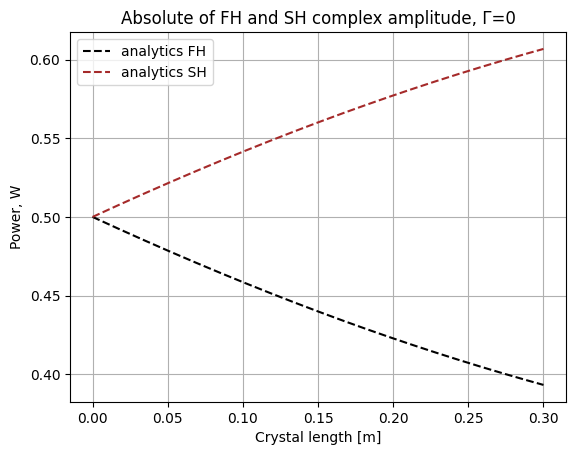

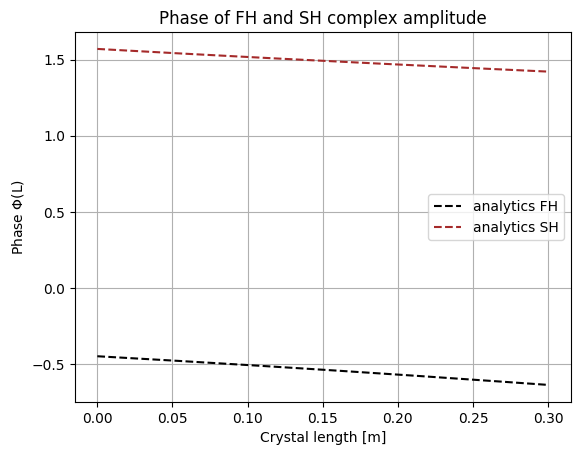

In [52]:
## Display results ###
#Amplitude
plt.figure()
plt.title("Absolute of FH and SH complex amplitude, Γ=0")

plt.plot(L, np.abs(A1_an)**2, label = "analytics FH", color='black', linestyle='--')
plt.plot(L, np.abs(A2_an)**2, label = "analytics SH", color='brown', linestyle='--')

plt.xlabel("Crystal length [m]")
#plt.ylabel("|A|^2")
plt.ylabel('Power, W')	

plt.legend()
plt.grid()
plt.show()

#Phase
plt.figure()
plt.title("Phase of FH and SH complex amplitude")
plt.plot(L, np.angle(A1_an), label = "analytics FH", color='black', linestyle='--')
plt.plot(L, np.angle(A2_an), label = "analytics SH", color='brown', linestyle='--')
if type=='dimensionless':
    plt.xlabel("Dimensionless crystal length")
    plt.xticks([1, 2,3], ["l", "2l", '3l'])  
else:
    plt.xlabel("Crystal length [m]")

plt.ylabel("Phase "+ r"$\Phi$" +"(L)")
plt.legend()
plt.grid()
plt.show()

